In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:15000]
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[:7000]
traj2.add_fusion(0, 1, 2)  # A + B -> C ! (0)
traj2.add_fusion(0, 2, 3)  # A + C -> D
traj2.add_fusion(0, 3, 2)  # A + D -> C
traj2.add_fusion(1, 2, 3)  # B + C -> D
traj2.add_fission(2, 0, 1) # C -> A + B ! (4)
traj2.add_fission(0, 1, 2) # A -> B + C
traj2.add_conversion(0, 1) # A -> B
traj2.add_conversion(0, 3) # A -> D ! (7)
traj2.add_conversion(3, 0) # D -> A ! (8)
traj2.add_conversion(0, 2) # A -> C
traj2.add_conversion(1, 2) # B -> C
traj2.add_conversion(2, 3) # C -> D
traj2.update()

max counts = 6000.0, min nonzero counts = 1.0
max counts = 9000.0, min nonzero counts = 1.0


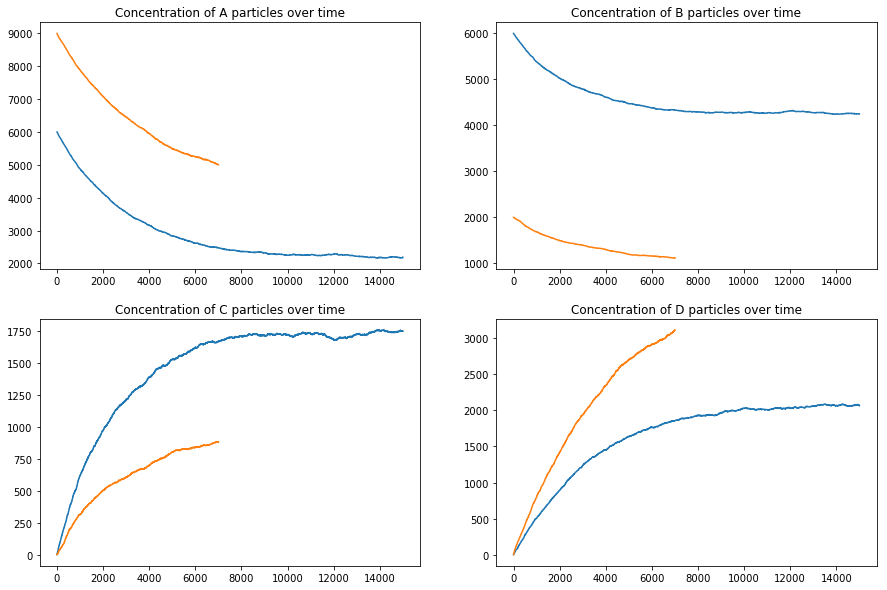

In [3]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj2.n_time_steps), traj2.counts[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [ ]:
cv = pat.CV(traj, traj2)
alpha, cv_result = cv.find_alpha_recurse(n_grid_points=8, njobs=8, return_cv_result=True, 
                                 train_indices=range(0, traj.n_time_steps//3), 
                                 test_indices=range(0, traj.n_time_steps//2))
print("found alpha=%s" % alpha)

In [ ]:
plt.plot(cv_result.alphas, cv_result.costs_test)

In [ ]:
cv = pat.CV(traj, traj2)
alpha_2, cv_result_2 = cv.find_alpha_recurse(njobs=16, return_cv_result=True, n_grid_points=16, 
                                 train_indices=range(0, traj.n_time_steps//3), 
                                 test_indices=range(0, traj.n_time_steps//2), initial_interval=np.linspace(0, 20000, num=64))
print("found alpha=%s" % alpha_2)
plt.plot(cv_result_2.alphas, cv_result_2.costs_test)

In [ ]:
cv = pat.CV(traj, traj2)
alpha_3, cv_result_3 = cv.find_alpha_recurse(njobs=16, return_cv_result=True, n_grid_points=16, 
                                 train_indices=range(0, traj.n_time_steps//3), 
                                 test_indices=range(0, traj.n_time_steps//2), initial_interval=np.linspace(0, 100000, num=64))
print("found alpha=%s" % alpha_2)
plt.plot(cv_result_3.alphas, cv_result_3.costs_test)

In [ ]:
xi = traj.estimate(alpha_2)
print("found xi: {}".format(xi))

In [ ]:
xi[[0, 4, 7, 8]]

In [ ]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha_2)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha_2)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [ ]:
xi = traj.estimate(736.670977856163)
print("found xi: {}".format(xi))
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha_3)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

# sklearn

In [8]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:15000]
traj.update()
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[:7000]
traj2.update()
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
#bfc.add_fusion(0, 2, 3)  # A + C -> D
#bfc.add_fusion(0, 3, 2)  # A + D -> C
#bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
#bfc.add_fission(0, 1, 2) # A -> B + C
#bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D
estimator = ReaDDyElasticNetEstimator(traj, bfc, 1. / (2. * traj.n_species * traj.n_time_steps), alpha=0)
estimator.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

max counts = 6000.0, min nonzero counts = 1.0
max counts = 6000.0, min nonzero counts = 1.0


ReaDDyElasticNetEstimator(alpha=0,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f32e2c7dba8>,
             init_xi=array([ 0.5,  0.5,  0.5,  0.5]), l1_ratio=1.0,
             scale=8.333333333333334e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7f32e2c6c860>])

coeffs=[  1.99452826e-06   1.67754527e-04   9.53914284e-03   9.55332536e-03]


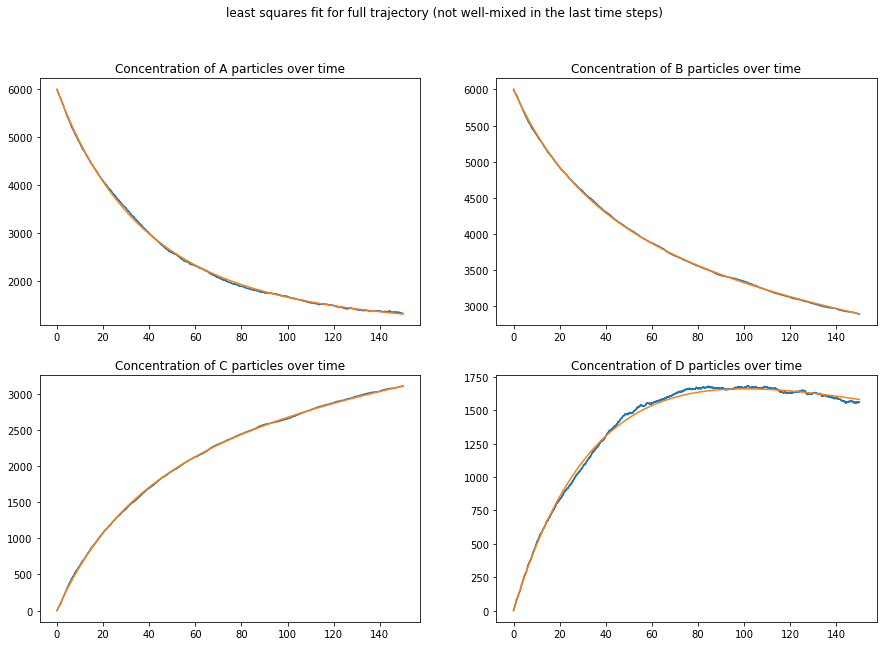

In [10]:
print("coeffs=%s" % estimator.coefficients_)
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [11]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:15000]
traj.update()
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[:7000]
traj2.update()
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)  # A + B -> C
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D
bfc.add_fission(2, 0, 1) # C -> A + B
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D
bfc.add_conversion(3, 0) # D -> A
bfc.add_conversion(0, 2) # A -> C
bfc.add_conversion(1, 2) # B -> C
bfc.add_conversion(2, 3) # C -> D
estimator = ReaDDyElasticNetEstimator(traj, bfc, 1. / (2. * traj.n_species * traj.n_time_steps))

max counts = 6000.0, min nonzero counts = 1.0
max counts = 6000.0, min nonzero counts = 1.0


In [3]:
parameter_grid = []
for alpha in  np.arange(0, 3000, 500):
    for l1_ratio in np.arange(0, 1, .2):
            parameter_grid.append({
                'alpha': [alpha], 
                'l1_ratio': [l1_ratio],
                'init_xi': [np.random.random(bfc.n_basis_functions) for _ in range(5)]})
gs = GridSearchCV(estimator, parameter_grid, n_jobs=8, cv=TimeSeriesSplit(3))

In [4]:
gs.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=ReaDDyElasticNetEstimator(alpha=1.0,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7fec5c6e8828>,
             init_xi=array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5]),
             l1_ratio=1.0, scale=8.333333333333334e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7fec2a96e438>]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid=[{'alpha': [0], 'l1_ratio': [0.0], 'init_xi': [array([ 0.97579,  0.29902,  0.49403,  0.73447,  0.98949,  0.28228,
        0.73426,  0.66966,  0.14302,  0.73359,  0.18102,  0.31095]), array([ 0.97692,  0.92384,  0.83812,  0.56899,  0.53241,  0.74489,
        0.82192,  0.5144 ,  0.45501,  0... 0.77681,  0.47248,  0.79525,
        0.95658,  0.05553,  0.39465,  0.57015,  0.27046,  0.08654])]}],
       pre_dispatch='2*n_jobs', refit=True, return_trai

In [5]:
print(gs.best_params_)
best_est = gs.best_estimator_



{'alpha': 500, 'init_xi': array([ 0.36759059,  0.04086877,  0.79871228,  0.76362431,  0.12492168,
        0.17172593,  0.47608255,  0.54305495,  0.34989108,  0.75576385,
        0.36332342,  0.26007385]), 'l1_ratio': 0.60000000000000009}


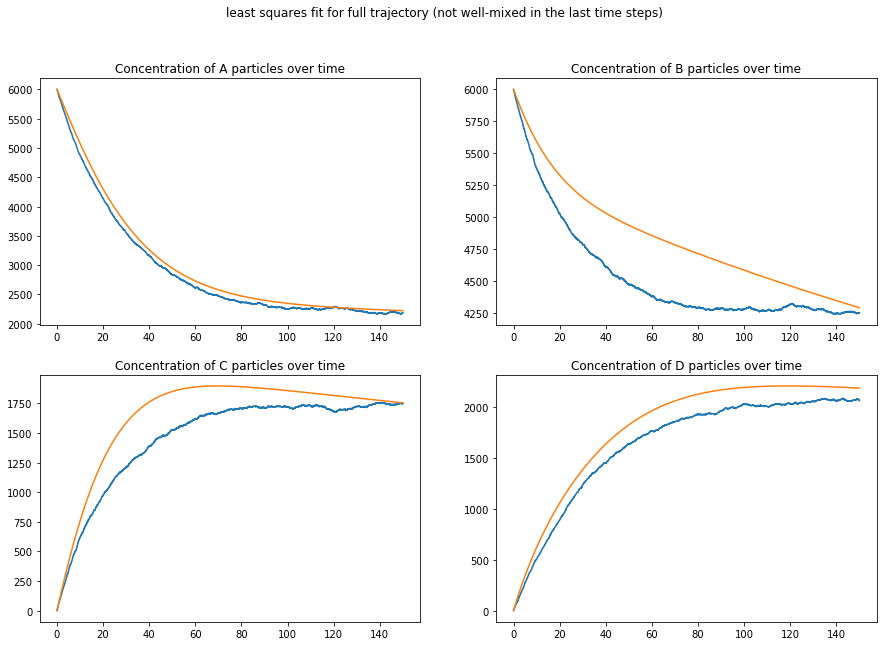

In [6]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(best_est.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [7]:
best_est.coefficients_

array([  3.77530628e-09,   8.02217767e-07,   1.03416639e-05,
         0.00000000e+00,   2.08666546e-02,   3.03330553e-03,
         6.56484672e-11,   1.28728576e-02,   2.31979814e-02,
         0.00000000e+00,   1.13634823e-02,   3.89015729e-02])

# start estimator with best conditions

In [14]:
start_conditions = ReaDDyElasticNetEstimator(traj, bfc, 1. / (2. * traj.n_species * traj.n_time_steps), alpha=500, l1_ratio=.6, init_xi=np.array([1.99452826e-06, 0.0, 0.0, .0, 1.67754527e-04, 0, 0, 9.53914284e-03, 9.55332536e-03, 0, 0, 0]))

In [15]:
estimator.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

ReaDDyElasticNetEstimator(alpha=500,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f32e27d75f8>,
             init_xi=array([  1.99453e-06,   0.00000e+00,   0.00000e+00,   0.00000e+00,
         1.67755e-04,   0.00000e+00,   0.00000e+00,   9.53914e-03,
         9.55333e-03,   0.00000e+00,   0.00000e+00,   0.00000e+00]),
             l1_ratio=0.6, scale=8.333333333333334e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7f32e2744630>])

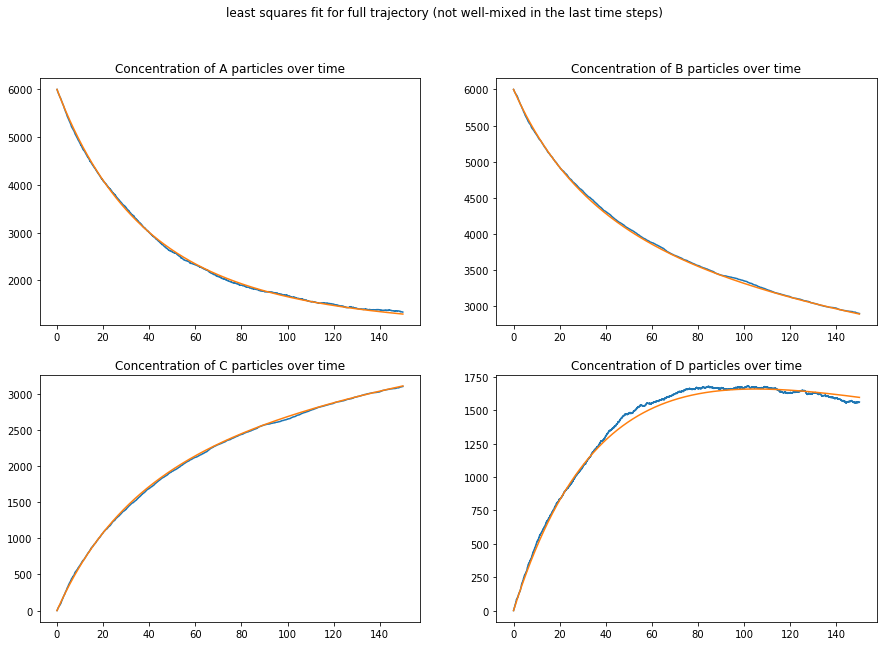

In [16]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

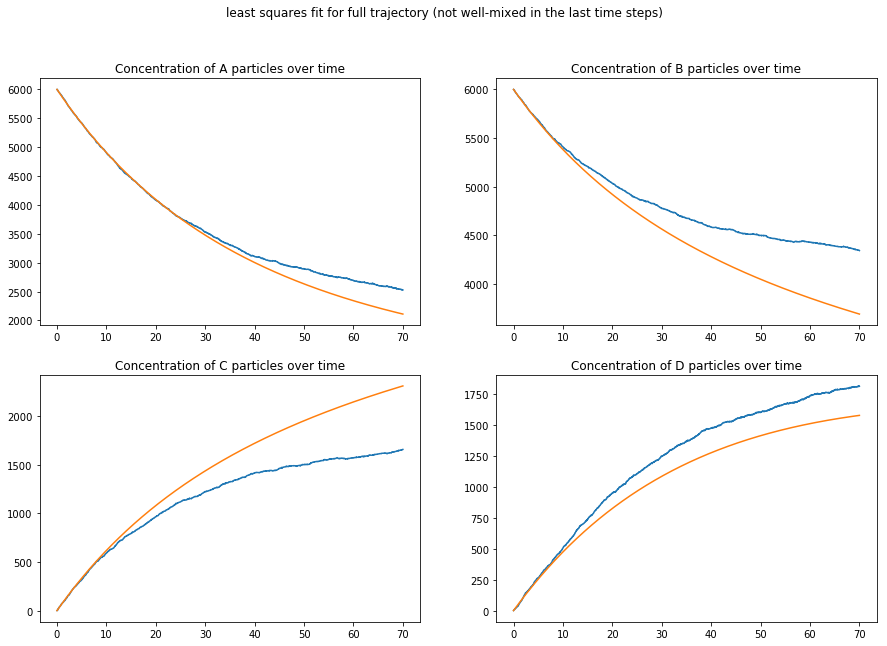

In [17]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj2.counts[0], np.arange(0, traj2.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj2.n_species):
    axes[i].plot(np.arange(0, traj2.n_time_steps*.01, .01), traj2.counts[:,i])
    axes[i].plot(np.arange(0, traj2.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()